This notebook is intended to produce the vizualisations of Figure 2 from the paper. 

It represents a comparison between our proposal and the barycentric projection obtained with the Robbins-Monro algorithm referenced in the section "Related Works". 

Hereafter, the objects for our procedure are naimed similarly with the ones related to the other procedure, which are labelled at the end with `RM`. This enables to differentiate the steps within the lines of code. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random  
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import beta

In [9]:
sns.set()

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

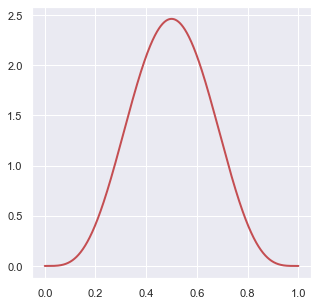

In [10]:
# Choice of the distibution beta

plt.figure(figsize=(5,5))
a, b = 5, 5

z = np.linspace(beta.ppf(0, a, b), beta.ppf(1, a, b), 1000)
plt.plot(z, beta.pdf(z, a, b),'r-', lw=2, label='Densité de la loi beta')

The next cell vizualises the true quantile function of the beta distribution. Knowing this true quantile function, the true dual optimal can be retrieved by the relation
$$
Q(x) = \nabla\left(\frac{1}{2}x^2 - u(x)\right).
$$

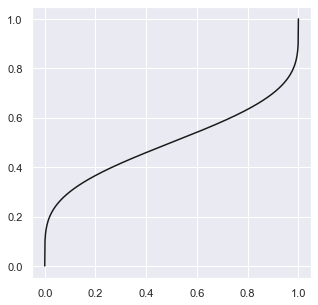

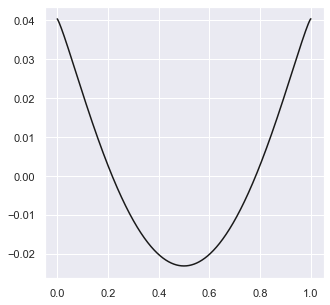

In [11]:

# Choice of a regular grid of quantile levels
nb_pts = 1000
grid_x = np.linspace(0,1,nb_pts)

# Quantile function
T0 = beta.ppf(grid_x, a, b)

plt.figure(figsize=(5,5))
plt.plot(grid_x,T0,'k')

# Optimal dual vector
u0 = grid_x**2/2-np.cumsum(T0)/len(grid_x)
u0 = u0-np.mean(u0)

plt.figure(figsize=(5,5))
plt.plot(grid_x,u0,'k')

### The next cell defines several functions for the FFT-based procedure.

In [12]:
def cost(x,Y):
    """
    Squared euclidean distance between x and the J points of Y.
    if x is the ith point of the support of the distribution, 
    the result is the ith line of the cost matrix.
    
    """
    if (choix_cost == 0):
        return(0.5*(Y-x)**2)
    else:
        return(0.5*np.min([np.sqrt((Y-x)**2),1-np.sqrt((Y-x)**2)],axis=0)**2)
    

def c_transform_fft(u, grid_unif, y, eps=0.1):
    """Calculate the c_transform of u"""
    arg = (u - cost(grid_unif, y))/eps
    to_sum = np.exp(arg)
    return(-eps*np.log(np.mean(to_sum)))
    
def grad_heps_fft(u, grid_unif, y, eps=0.1):
    """
    Calculate the gradient h_eps 
    """

    F_u = np.exp((u - cost(grid_unif, y))/eps)
    argD = np.mean(F_u)
    grad = -np.fft.fft(F_u)/argD

    return(grad)

def h_eps_fft(u, grid_unif, y, eps=0.1):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(c_transform_fft(u, grid_unif, y, eps)-eps)

def Robbins_Monro_Algo_fft(grid_unif, Y, eps=0.1, gamma= 1, c = 3/4, alpha= 0, epoch = 1):   
    p = len(grid_unif)
    n_iter = len(Y)*epoch
    
    # Sample the observations from Y for the upcoming iterations
    sample = np.random.choice(a=np.arange(len(Y)), size=n_iter)
    
    # Choice of the matrix W
    N = len(grid_unif)
    freqs = np.fft.fftfreq(N)
    freqs[0] = 1/N
    W = 1/(N*np.abs(freqs))**alpha
 
    # Storage of the recursive estimators
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter)
    u_storage = np.zeros((n_iter,p))

    # Initialisation of the vector u
    u = np.zeros(p)
    fft_u = np.fft.fft(u)
    
    # First iteration.
    y_0 = Y[sample[0]] 
    W_hat_storage[0] = h_eps_fft(u, grid_unif, y_0, eps)
    h_eps_storage[0] = h_eps_fft(u, grid_unif, y_0, eps)

    # Robbins Monro scheme.
    for k in range(1,n_iter):

        # sample y from nu
        y = Y[sample[k]]
        
        # iterate fft_u and centering the integral of the corresponding function
        u = np.real(np.fft.ifft(fft_u))
        fft_u = fft_u + gamma/((k+1)**c) * W * grad_heps_fft(u, grid_unif, y, eps)
        fft_u[0] = 0
        
        # Storage of h_eps at point (u,y).
        h_eps_storage[k] = h_eps_fft(u, grid_unif, y, eps)
    
        # Approximation of the Sinkhorn divergence
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        
        # Storage of u at each iteration
        u = u-np.mean(u)
        u_storage[k,:] = u 
    
    L = [u_storage, W_hat_storage]
    
    return(L)


### The next cell defines functions for the regularized SGD, namely a Robbins-Monro scheme followed by the barycentric projection

In [13]:
def c_transform(v, x, Y, nu, eps=0):
    """Calculate the c_transform of g"""
    if eps > 0:
        arg = (v - cost(x, Y))/eps
        to_sum = np.exp(arg)*nu
        return(-eps*np.log(np.sum(to_sum)))
    else:
        cost_x = cost(x,Y)
        return(np.min(cost_x-v))
    
def grad_heps(v, x, Y, nu, eps=0):
    """
    Calculate the gradient h_eps 
    """
    if eps > 0:
        pi = nu * np.exp((v-cost(x,Y))/eps)
        pi = pi/pi.sum()
        return(nu-pi)
    else:
        cost_x = cost(x,Y)
        j_star = np.argmin(cost_x - v)
        to_return = nu.copy()
        to_return[j_star] = nu[j_star] - 1
        return(to_return)

def h_eps(v, x, Y, nu, eps=0):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(np.sum(v*nu)+c_transform(v,x,Y,nu,eps)-eps)

def Robbins_Monro_Algo(Y, nu, eps=0, n_iter=10000, v=0):
    """
    Function that calculates the approximation of the regulaized Wasserstein
    distance between mu (the uniform distribution on [0,1]) and nu (empirical measure)
    thanks to the Robbins-Monro Algorithm. Y denotes the support of target 
    distribution nu that are the weights of the distributions.
    """    
    c = 0.51
    # c = 1
    
    # Définition de la suite des pas.
    if eps > 0:
        gamma = eps/(1.9 * min(nu))
    else:
        gamma = 0.001/(1.9 * min(nu))
    
    # Stockage des estimateurs recursifs.
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter)
    #bar_W_hat_storage = np.zeros(n_iter)
    #bar_h_eps_storage = np.zeros(n_iter)
    
    # Tirage des X_n selon la distribution mu.
    X = np.random.uniform(size=n_iter)

    # Initialisation du vecteur dual v
    v = v - np.mean(v)
    #bar_v = v
    
    # Premiere iteration pour lancer la boucle.
    x_0 = X[1]
    W_hat_storage[0] = h_eps(v, x_0, Y, nu, eps)
    h_eps_storage[0] = h_eps(v, x_0, Y, nu, eps)
    #bar_W_hat_storage[0] = h_eps(bar_v, x_0, Y, nu, eps)
    #bar_h_eps_storage[0] = h_eps(bar_v, x_0, Y, nu, eps)
    
    # Boucle de Robbins Monro.
    for k in range(1,n_iter):
        #if k % 10000 == 0:
        #    print(k)
        # Tirage d'une réalisation selon la loi mu.
        x = X[k]
    
        # Mise à jour de la valeur de v.
        v = v + gamma/((k+1)**c) * grad_heps(v, x, Y, nu, eps)
        #bar_v = ((k-1)/k)*bar_v + v/k
        #bar_h_eps_storage[k] = h_eps(bar_v, x, Y, nu, eps)
        
        # Stockage de la valeur de h_eps au point (x,g).
        h_eps_storage[k] = h_eps(v, x, Y, nu, eps)
    
        # Evaluation de l'approximation de la divergence de Sinkhorn.
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        #bar_W_hat_storage[k] = k/(k+1) * bar_W_hat_storage[k-1] + 1/(k+1) * bar_h_eps_storage[k]
        
    #L = [v, W_hat_storage, bar_v, bar_W_hat_storage]
    L = [v, W_hat_storage]
    return(L)

def Gauss_Newton_Sto_Algo(Y, nu, eps=1, n_iter=50000, v=0):
    """
    Function that calculate the approximation of the Wasserstein distance between
    (the uniform distribution on [0,1]) and nu (empirical measure)
    thanks to the Gauss Newton Stochastic Algorithm. Y denotes the support of target 
    distribution nu that are the weights of the distributions.
    """
    J = len(Y)
    
    # Stockage des estimateurs recursifs.
    h_eps_storage2 = np.zeros(n_iter)
    W_hat_storage2 = np.zeros(n_iter)
    
    # Tirage des X_n selon la distribution mu
    X = np.random.uniform(size=n_iter)
    
    # Initialisation du vecteur dual v
    v2 = v

    # Premiere iteration pour lancer la boucle.
    x_0 = X[1]

    h_eps_storage2[0] = h_eps(v2, x_0, Y, nu, eps)
    W_hat_storage2[0] = h_eps(v2, x_0, Y, nu, eps)
    
    S2_inv = -np.eye(J)
    
    # Boucle de Newton    
    for k in range(1,n_iter):
        # Tirage d'une réalisation selon la loi mu.
        x = X[k]

        # Mise à jour de la valeur de v.
        grad2 = grad_heps(v2, x, Y, nu, eps)
        
        # SGN : Approche par Ricatti
  
        # Deterministic case : Construction de Z
        Nu = np.array(nu).reshape(J, 1)
        pos = int(k-np.floor(k/J)*J)
        e = np.zeros(J)
        e[pos] = np.sqrt(nu[pos])
        Z = np.array(e).reshape(J, 1)
        
        # Value of the gradient vector
        G = np.array(grad2).reshape(J, 1)
    
        # Riccati Etape 1
        SZ = np.dot(S2_inv,Z)  
        ZS = np.dot(np.transpose(Z),S2_inv)
        beta = 0.49
        # S2_inv_aux = S2_inv -(1/(np.dot(np.transpose(Z),SZ)-(1/J)*(int(np.floor(k/J))+1)**beta))*np.dot(SZ,ZS) # Cas gamma = J
        S2_inv_aux = S2_inv # Cas sans régularisation gamma = 0
        
        # Riccati Etape 2
        SG = np.dot(S2_inv_aux,G)  
        GS = np.dot(np.transpose(G),S2_inv_aux)
        S2_inv = S2_inv_aux -(1/(np.dot(np.transpose(G),SG)-1))*np.dot(SG,GS)
        
        v2 = v2 - np.dot(S2_inv, grad2)
        
        # Projection
        v2 = v2 - np.mean(v2)
        
        # Stockage de la valeur de h_eps au point (x,v).
        h_eps_storage2[k] = h_eps(v2, x, Y, nu, eps)
        
        # Evaluation de l'approximation de la divergence de Sinkhorn.
        W_hat_storage2[k] = k/(k+1) * W_hat_storage2[k-1] + 1/(k+1) * h_eps_storage2[k]

    L = [v2, W_hat_storage2]
    return(L)

def Barycentric_Projection(x, Y, nu, eps, v):
    """
    Function that calculates the barycentric projection
    """ 
    arg = (v - cost(x, Y))/eps
    to_sum = np.exp(arg)*nu
    weights = to_sum/(np.sum(to_sum))
    return(sum(Y*weights))
    

### We first select the considered cost

In [17]:
choix_cost = 1 # 0 = quadratic cost ; 1 = torus cost

In [19]:
# Monte-Carlo simulations with grid of values for epsilon
nb_rep = 20

# grid for epsilon
nb_eps = 20
grid_eps = np.round(np.linspace(0.005,0.5,nb_eps),3)

# nu is seen as a discrete measure with J observations
J = 100
nu = 1/J*np.ones(J)

epoch = 10**3
n_iter_fft = J*epoch
n_iter_RM = 10**5

freqs = np.fft.fftfreq(nb_pts)

err_hat_T0 = np.zeros([nb_rep,nb_pts])
err_hat_Teps = np.zeros([nb_eps,nb_rep,nb_pts])
err_hat_Teps_RM = np.zeros([nb_eps,nb_rep,nb_pts])

err_hat_u0 = np.zeros([nb_rep,nb_pts])
err_hat_ueps = np.zeros([nb_eps,nb_rep,nb_pts])
err_hat_ueps_RM = np.zeros([nb_eps,nb_rep,nb_pts])

hat_Weps = np.zeros([nb_eps,nb_rep,n_iter_fft])
hat_Weps_RM = np.zeros([nb_eps,nb_rep,n_iter_RM])

print('Itération numéro : ', end='')
    
for nb in range(0,nb_rep):
    print('{}-'.format(nb), end='')

    # Simulation des données
    Y = beta.rvs(a, b, size=J)
    
    # Empirical quantiles
    hat_T0 = np.quantile(a = Y, q = grid_x)
    err_hat_T0[nb,:] = (hat_T0-T0)**2
    
    hat_u0 = grid_x**2/2-np.cumsum(hat_T0)*(grid_x[1]-grid_x[0])
    hat_u0 = hat_u0-np.mean(hat_u0)
    err_hat_u0[nb,:] = (hat_u0-u0)**2
    
    for m_eps in range(0,nb_eps):

        # Choix de la régularisation
        eps = grid_eps[m_eps]
        
        # Taux d'apprentissage fixé en fonction de epsilon
        gamma = eps
        
        # Compute the regularized maps by RM-FTT
        res_RM_fft = Robbins_Monro_Algo_fft(grid_x, Y, eps=eps, gamma = gamma, c = 3/4, alpha = 2, epoch = epoch)
        hat_u = res_RM_fft[0][n_iter_fft-1]
        hat_W = res_RM_fft[1]
        
        hat_u_fft =np.fft.fft(hat_u)
        hat_T = grid_x - np.real(np.fft.ifft(2*np.pi*1j*freqs*hat_u_fft))/(grid_x[1]-grid_x[0])
        
        # Compute the regularized maps by RM
        res_RM = Robbins_Monro_Algo(Y, nu, eps=eps, n_iter=n_iter_RM)
        v_last_RM = res_RM[0]
        hat_W_RM = res_RM[1]
            
        # Compute the regularized maps by barycentric projection RM
        hat_T_RM = np.zeros(nb_pts)
        for i in range(0,nb_pts):
            x = grid_x[i]
            hat_T_RM[i] = Barycentric_Projection(x, Y, nu, eps, v=v_last_RM)
            
        hat_u_RM = grid_x**2/2-np.cumsum(hat_T_RM)*(grid_x[1]-grid_x[0])
        hat_u_RM = hat_u_RM-np.mean(hat_u_RM)
        
        # Store the results
        hat_Weps[m_eps,nb,:] = hat_W
        hat_Weps_RM[m_eps,nb,:] = hat_W_RM
        
        err_hat_Teps[m_eps,nb,:] = (hat_T-T0)**2
        err_hat_Teps_RM[m_eps,nb,:] = (hat_T_RM-T0)**2 
            
        err_hat_ueps[m_eps,nb,:] = (hat_u-u0)**2 
        err_hat_ueps_RM[m_eps,nb,:] = (hat_u_RM-u0)**2

print(' Fin des itérations', end='\n')

Itération numéro : 0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19- Fin des itérations


The next cell plots the local log-error of our FFT-based scheme. 

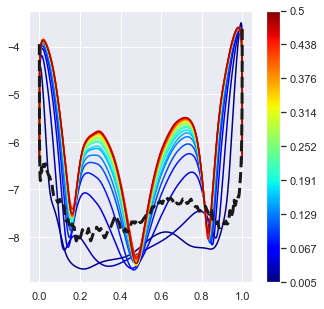

<Figure size 432x288 with 0 Axes>

In [21]:
# Choice of the colormap
normalize = mcolors.Normalize(vmin=0, vmax=nb_eps)
colormap = cm.jet

# Plot - log-scale
plt.figure(figsize=(5,5))

for m_eps in range(0,nb_eps):
    plt.plot(grid_x,np.log(err_hat_Teps[m_eps,:,:].mean(axis=0)), color=colormap(normalize(m_eps)))

plt.plot(grid_x,np.log(err_hat_T0.mean(axis=0)),'--k',linewidth = 3)
    
# Setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(grid_eps)
cbar = plt.colorbar(scalarmappaple)
plot_grid_eps = np.round(np.linspace(0.005,0.5,9),3)
cbar.ax.set_yticklabels(plot_grid_eps)
    
# Show the figure
plt.show()

if (choix_cost == 0):
    plt.savefig('Figures/fid_1d_log_err_Teps_beta_discrete_cost_quadratic.eps',bbox_inches='tight')
else:
    plt.savefig('Figures/fid_1d_log_err_Teps_beta_discrete_cost_torus.eps',bbox_inches='tight')


The next cell plots the local log-error of the RM scheme, (the entropic map based on semi-discrete OT).

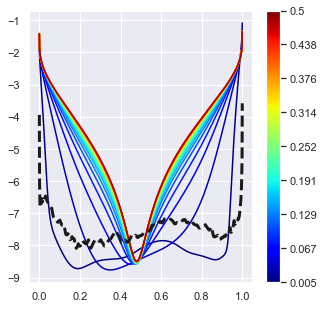

<Figure size 432x288 with 0 Axes>

In [22]:

# Choice of the colormap
normalize = mcolors.Normalize(vmin=0, vmax=nb_eps)
colormap = cm.jet


# Plot - log-scale
plt.figure(figsize=(5,5))

for m_eps in range(0,nb_eps):
    plt.plot(grid_x,np.log(err_hat_Teps_RM[m_eps,:,:].mean(axis=0)), color=colormap(normalize(m_eps)))

plt.plot(grid_x,np.log(err_hat_T0.mean(axis=0)),'--k',linewidth = 3)
    
# Setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(grid_eps)
cbar = plt.colorbar(scalarmappaple)
plot_grid_eps = np.round(np.linspace(0.005,0.5,9),3)
cbar.ax.set_yticklabels(plot_grid_eps)
    
# Show the figure
plt.show()

if (choix_cost == 0):
    plt.savefig('Figures/fid_1d_log_err_Teps_RM_beta_discrete_cost_quadratic.eps',bbox_inches='tight')
else:
    plt.savefig('Figures/fid_1d_log_err_Teps_RM_beta_discrete_cost_torus.eps',bbox_inches='tight')